In [1]:
import torch.nn as nn
import numpy as np
import gym
from seagul.rl.ars.meta_ars import MetaARSAgent
import matplotlib.pyplot as plt
import torch
import dill
import seagul.envs
import pybullet_envs
import pickle
from scipy.signal import find_peaks

from common import *

/home/sgillen/work/seagul/seagul/envs/__init__.py:56: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


In [2]:
meta_agent = pickle.load(open("meta_hmap_hopper_allwork", "rb"))
agent0 = meta_agent.agents[4]

In [3]:
env_name = "hmap_hopper-v0"
seed = 4
env = gym.make(env_name,slope=0)
#env = gym.make("Hopper-v2")

#agent = meta_agent.agents[seed]
obs, act, rew, _ = do_rollout(env, agent0.model, render=False, ep_length=1000)
print(sum(rew))

running build_ext
[2316.07178855]


In [7]:
agent0.env_config={"slope":0}
#agent0.postprocessor = mdim_div
agent0.learn(100);

0 : mean return: 2747.156590912979, fps:29806.57842233683
10 : mean return: 2509.9627019901754, fps:33234.29779964478
20 : mean return: 2692.799991110183, fps:34035.72373933347
30 : mean return: 2557.3739681508087, fps:33172.22490268854
40 : mean return: 2572.819559423054, fps:28884.28980273316
50 : mean return: 2515.1325786147086, fps:32636.61001144016
60 : mean return: 2499.188904508751, fps:32748.936980645754
70 : mean return: 2559.8504691358553, fps:33672.62735684537
80 : mean return: 2941.8669088682527, fps:34637.26023259577
90 : mean return: 2772.7440694325833, fps:34367.27324496907


In [8]:
import copy
agent_list = []
slope_set = [-.01, 0, .01]
for slope in slope_set:
    agent = copy.deepcopy(agent0)
    agent.postprocessor = mdim_div
    agent.env_config = {"slope":slope}
    agent.learn(100)
    agent_list.append(agent)

0 : mean return: 566.0497956058066, fps:24082.8239788498
10 : mean return: 889.565265548534, fps:28053.24631727475
20 : mean return: 1173.5832887451747, fps:24844.676212784707
30 : mean return: 1496.8267336806803, fps:28534.129254752894
40 : mean return: 1511.4080277990906, fps:28643.197391604834
50 : mean return: 1490.4790509815762, fps:26285.375718307678
60 : mean return: 1671.849221408208, fps:27022.553710871307
70 : mean return: 1715.3874163068685, fps:29627.722763305497
80 : mean return: 1620.9067444676784, fps:26886.492575607343
90 : mean return: 1450.7312058483833, fps:28660.310212467037
0 : mean return: 2811.688381263946, fps:34011.95655687588
10 : mean return: 2834.271893230779, fps:33044.8801564075
20 : mean return: 2842.6100524498265, fps:30833.18635358786
30 : mean return: 2725.2903294127946, fps:30847.275277283115
40 : mean return: 2714.894640476466, fps:29633.879418173507
50 : mean return: 2373.925711409351, fps:33323.658050216094
60 : mean return: 2824.2527575402596, fps

In [9]:
import xarray as xr

n_runs = 5
data = xr.DataArray(np.zeros((len(slope_set), len(agent_list), n_runs)),
                    dims=("slope", "agent", "run"))

for i, slope in enumerate(slope_set):
    env = gym.make(env_name, slope=slope)
    for j, agent in enumerate(agent_list):
        for run in range(n_runs):
            obs,act,rew,_ = do_rollout(env, agent.model)
            data.loc[i, j, run] = sum(rew).item()
            

In [10]:
data.mean(dim='run')

<xarray.DataArray (slope: 3, agent: 3)>
array([[1818.99538557, 1445.76674916, -192.22752605],
       [2939.8631122 , 3136.82349639, 1836.85809305],
       [1549.54497244, 1566.74580886, 2370.52195636]])
Dimensions without coordinates: slope, agent

False
11 poincare snapshots, 12 states in mesh
False
11 poincare snapshots, 23 states in mesh
True
4 poincare snapshots, 27 states in mesh


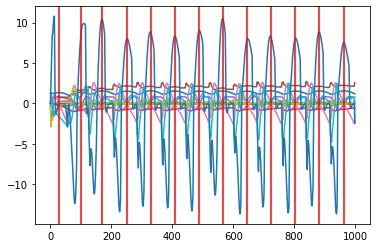

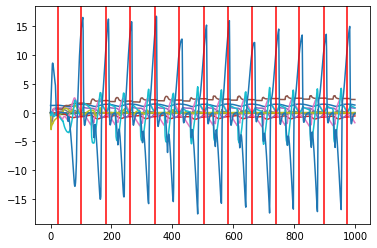

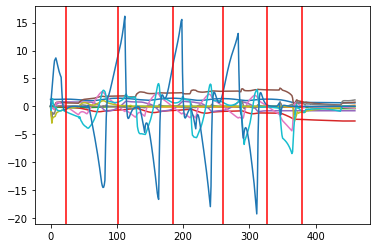

<Figure size 432x288 with 0 Axes>

In [12]:
#normal_seed  = 6
#noise_seed = 0 or 8

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    #tilted = np.abs(ob[:,1]) > .2 
    short = ob[:,0] < .7
    #return np.logical_or(tilted, short)
    return short

from common import *
from collections import namedtuple

class MeshBox:
    def __init__(self, state, iden, freq):
        self.state = state
        self.id = iden
        self.freq = freq
        
        self.succ_list = []
        self.pred_list = []
            
        self.ttl = 0
        self.opt_controller = None

delta = .1;
#pols = #policy_dict[post_names[1]][0:3]
pols = [agent.model for agent in agent_list]
npol = pols[0]


mesh = BoxMesh(delta); mdim_l = []


fail_state = np.ones_like(env.reset())*100
fail_id = 0
mesh[fail_state] = MeshBox(fail_state, iden = 0, freq = 1)

env = gym.make("hmap_hopper-v0", slope=0)

for policy in pols:
    obs, acts, rews, uc_obs = do_rollout(env, policy, ep_length=1000, return_on_done=True)
    peak_idx,_ = find_peaks(uc_obs[:,0], distance=20)


    for o in uc_obs[peak_idx[2:],:]:
        key = (o - npol.state_mean)/npol.state_std

        if key in mesh:
            mesh[key].freq +=1
        else:
            mesh[key] =  MeshBox(o, iden = len(mesh), freq = 1)


    plt.plot(uc_obs);
    peak_idx,_ = find_peaks(uc_obs[:,0], distance=20)

    for i in peak_idx:
        plt.axvline(x=i, color='r')

    print(fail_cond(obs).any())

    print(f"{len(peak_idx[2:])} poincare snapshots, {len(mesh)} states in mesh")
    plt.figure();

In [13]:
from multiprocessing import Pool
from itertools import repeat

def do_explore_rollout(args):
    policy, init_state, trial_num = args
    force = np.zeros(2)
    env.seed(trial_num)
    np.random.seed(trial_num)
    env.seed(trial_num)
    obs, acts, rews, uc_obs = do_push_rollout_from_state(env, policy, init_state, force)    
    
    return np.asarray(uc_obs)

def do_push_rollout_from_state(env, policy, init_state, force, num_steps=100, force_steps = 1, render=False):
    act_list = []
    obs_list = []
    rew_list = []
    uc_obs_list = []

    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs_list.append(np.copy(obs))

        
        uc_obs_list.append(np.concatenate(
            [env.sim.data.qpos.flat[1:],
             env.sim.data.qvel.flat]))
        
        #x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act,_,_,_ = policy.step(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
    ep_obs = np.stack(obs_list)
    ep_uc_obs = np.stack(uc_obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)

    return ep_obs, ep_act, ep_rew, ep_uc_obs




start = time.time()
keys = list(mesh.keys())[1:]
i = 0 

with Pool(12, maxtasksperchild=1000) as pool:
    for init_key in keys:    
        i+=1 
        
        init_state = mesh[init_key].state
        init_id = mesh[init_key].id
        
        state_iter = repeat(init_state, len(pols))
        rollout_seed_iter = range(i*len(pols), i*len(pols)+len(pols))

        for j, res in enumerate(pool.imap(do_explore_rollout, zip(pols, state_iter, rollout_seed_iter))):
            obs = res
    
            peak_idx,_ = find_peaks(obs[:,0], distance=20)

            if len(peak_idx) != 1 or fail_cond(obs[:peak_idx[0]]).any():
                new_id = fail_id
                new_key = fail_state
            else:
                new_key = ((obs[peak_idx,:] - np.array(npol.state_mean))/np.array(npol.state_std)).squeeze()
                if new_key in mesh:
                    new_id = mesh[new_key].id
                    mesh[new_key].freq += 1
                else:
                    mesh[new_key] = MeshBox(obs[peak_idx, :].squeeze(), len(mesh), 1)
                    new_id = len(mesh)-1
                    keys.append(mesh.__keytransform__(new_key))
            
            mesh[init_key].succ_list.append(new_id)
            mesh[new_key].pred_list.append(init_id)
                        
                
        if i % 1000 == 0:
            print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")
            #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")
        
print(time.time() - start)

i; 1000, mdim: 1689, ratio: 0.5920663114268798
i; 2000, mdim: 3174, ratio: 0.630119722747322
i; 3000, mdim: 4428, ratio: 0.6775067750677507
i; 4000, mdim: 5634, ratio: 0.7099751508697195
i; 5000, mdim: 6775, ratio: 0.7380073800738007
i; 6000, mdim: 7892, ratio: 0.7602635580334516
i; 7000, mdim: 8986, ratio: 0.7789895392833296
i; 8000, mdim: 9975, ratio: 0.8020050125313283
i; 9000, mdim: 10970, ratio: 0.8204193254329991
i; 10000, mdim: 11889, ratio: 0.8411136344520145
i; 11000, mdim: 12859, ratio: 0.8554319931565441
i; 8000, mdim: 9975, ratio: 0.8020050125313283i; 12000, mdim: 13726, ratio: 0.8742532420224391
i; 13000, mdim: 14552, ratio: 0.8933479934029687
i; 14000, mdim: 15448, ratio: 0.9062661833247022
i; 15000, mdim: 16264, ratio: 0.9222823413674373
i; 16000, mdim: 17048, ratio: 0.9385265133740028
i; 17000, mdim: 17846, ratio: 0.9525944189174045
i; 18000, mdim: 18646, ratio: 0.9653544996245844
i; 19000, mdim: 19455, ratio: 0.9766126959650475
i; 20000, mdim: 20193, ratio: 0.990442232

In [14]:
print(mesh)

key = list(mesh.keys())[1]

mesh_map = {state.id:state for state in mesh.values()}

# Recursive TTL

def V(mesh_id):
    mesh_state = mesh_map[mesh_id]
    
    if mesh_state.visited:
        #print(f"{mesh_id} limit cycle detected")
        mesh_state.ttl = float('inf')
        return float('inf')
        
    if (np.asarray(mesh_state.state) == fail_state).all():
        #print(f"{mesh_id} returning 0")
        return 0
    
    elif mesh_state.ttl == 0:
        #print(f"{mesh_id} descending into {mesh_state.succ_list}")
        mesh_state.visited = True
        next_list = []
        
        for next_state_id in mesh_state.succ_list:
            V_next = V(next_state_id)
            if V_next == float('inf'):
                mesh_state.ttl = float('inf')
                mesh_state.opt_controller = len(next_list)
                return float('inf')
            else:
                next_list.append(V_next)
                
        mesh_state.ttl =  1 + max(next_list)
        mesh_state.opt_controller = next_list.index(max(next_list))

        #print(f"{mesh_id} resulting list was {next_list} , new ttl is {mesh_state.ttl}")
        return mesh_state.ttl
        
    else:
        #print(f"{mesh_id} returning ttl of {mesh_state.ttl}")
        return mesh_state.ttl
    
    
# Iterative TTL   
        
for state in mesh.values():
    state.ttl = 0
    state.visited = False
    
    
V(1)

inf

In [15]:
def do_opt_rollout_from_state(env, pols, init_state, obs_std=0, act_std=0, num_steps=1000, render=True):
    act_list = []
    obs_list = []
    rew_list = []
    uc_obs_list = []

    obs = my_reset(env, init_state)
    uc_obs = np.concatenate([env.sim.data.qpos.flat[1:], env.sim.data.qvel.flat])
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]
    pi = None

    
    out = 0
    inm = 0
    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
            
        obs_key = (uc_obs - npol.state_mean)/npol.state_std
        if not obs_key in mesh:
            out+=1
        else:
            if mesh[obs_key].opt_controller is None:
                V(mesh[obs_key].id)
            
            inm +=1
            policy = pols[mesh[obs_key].opt_controller] 
            print(f"going from pol {pi} to {mesh[obs_key].opt_controller}" )
            pi = mesh[obs_key].opt_controller

        #policy = pols[0]

        obs += np.random.randn(obs_size)*obs_std
        obs_list.append(np.copy(obs))
        
        uc_obs = torch.tensor(np.concatenate([env.sim.data.qpos.flat[1:], env.sim.data.qvel.flat]))
        uc_obs_list.append(np.copy(uc_obs))
        
        act,_,_,_ = policy.step(obs)
        act += np.random.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
    ep_obs = np.stack(obs_list)
    ep_uc_obs = np.stack(uc_obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)

    
    print(out, inm)
    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_uc_obs

#mesh_map = {state.id:state for state in mesh.values()}

do_opt_rollout_from_state(env, pols, mesh_map[20].state)

Creating window glfw
going from pol None to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
979 21


(array([[ 1.50014052e+00, -1.21079814e-01,  3.16249657e-03, ...,
         -1.07534318e-02,  1.04595898e-01,  1.00000000e+01],
        [ 1.50003037e+00, -1.20710278e-01,  2.97026693e-03, ...,
         -3.36382818e-02,  1.51546290e-01,  1.00000000e+01],
        [ 1.49937614e+00, -1.20446396e-01,  2.66995316e-03, ...,
         -3.96526728e-02,  3.64790102e-01,  9.60654958e+00],
        ...,
        [ 1.11716217e+00, -1.30531552e-01, -3.42155741e-03, ...,
         -4.62630216e-01, -2.98102945e+00, -4.93914235e+00],
        [ 1.12799340e+00, -1.31632724e-01, -7.19637247e-03, ...,
         -4.80866060e-01, -2.48632092e+00, -5.15180033e+00],
        [ 1.14106285e+00, -1.32532601e-01, -1.08990129e-02, ...,
         -4.44073962e-01, -2.17096575e+00, -5.64498794e+00]]),
 array([[ 0.25668578,  0.00821979, -0.28815982],
        [ 0.28132007,  0.1434143 , -0.27338276],
        [ 0.3057861 ,  0.02086692, -0.34763726],
        ...,
        [-0.00707558,  0.29954038, -2.34098009],
        [ 0.01501266